In [35]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class MazeEnv(gym.Env):
    def __init__(self, grid_size=(9, 9), start=(2, 2), goal=(7, 7), obstacles=[(5,2),(6,7),(4,8),(7,2)]):
        super(MazeEnv, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.state = start

        # Define action space (0: Up, 1: Down, 2: Left, 3: Right)
        self.action_space = spaces.Discrete(4)

        # Define state space
        self.observation_space = spaces.Tuple((spaces.Discrete(grid_size[0]), spaces.Discrete(grid_size[1])))

        # Define obstacles
        self.obstacles = obstacles if obstacles else [(2, 2), (3, 3)]

    def step(self, action):
        x, y = self.state

        if action == 0:  # Up
            x = max(x - 1, 0)
        elif action == 1:  # Down
            x = min(x + 1, self.grid_size[0] - 1)
        elif action == 2:  # Left
            y = max(y - 1, 0)
        elif action == 3:  # Right
            y = min(y + 1, self.grid_size[1] - 1)

        if (x, y) in self.obstacles:
            x, y = self.state  # Hit an obstacle, stay in place

        self.state = (x, y)

        # Reward system
        reward = 1 if self.state == self.goal else -0.1  # Small penalty to encourage shortest path
        done = self.state == self.goal

        return self.state, reward, done, {}

    def reset(self):
        self.state = self.start
        return self.state

    def render(self):
        grid = np.zeros(self.grid_size)
        grid[self.goal] = 2
        for ob in self.obstacles:
            grid[ob] = -1
        grid[self.state] = 1
        print(grid)



In [36]:
import random

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}  # Q-table for storing state-action values

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:  # Exploration
            return self.env.action_space.sample()
        else:  # Exploitation
            q_values = [self.get_q_value(state, a) for a in range(self.env.action_space.n)]
            return np.argmax(q_values)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = self.choose_action(next_state)
        old_value = self.get_q_value(state, action)
        next_value = self.get_q_value(next_state, best_next_action)

        # Q-learning update rule
        new_value = old_value + self.alpha * (reward + self.gamma * next_value - old_value)
        self.q_table[(state, action)] = new_value

    def train(self, episodes=1000):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
            if episode % 100 == 0:
                print(f"Episode {episode} complete")


In [37]:
# Initialize environment and agent
env = MazeEnv()
agent = QLearningAgent(env)

# Train the agent
agent.train(episodes=1000)

# Test the trained agent
state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    state, _, done, _ = env.step(action)
    env.render()  # Visualize the maze


Episode 0 complete
Episode 100 complete
Episode 200 complete
Episode 300 complete
Episode 400 complete
Episode 500 complete
Episode 600 complete
Episode 700 complete
Episode 800 complete
Episode 900 complete
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 

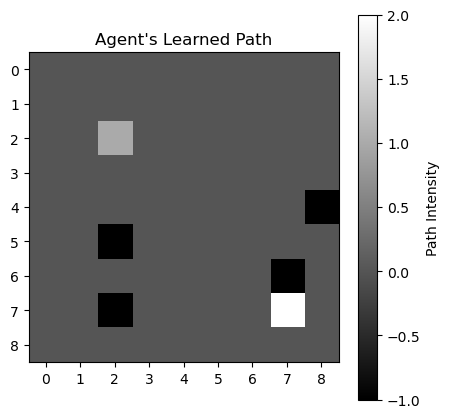

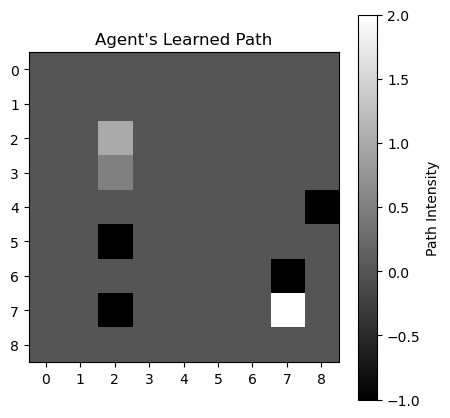

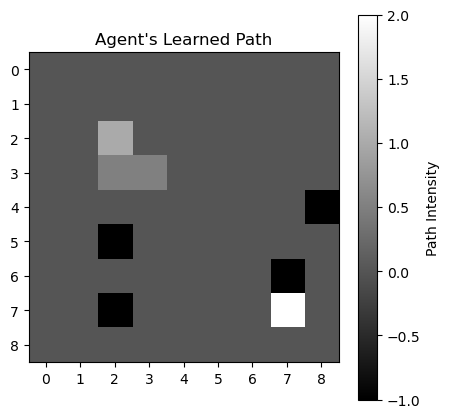

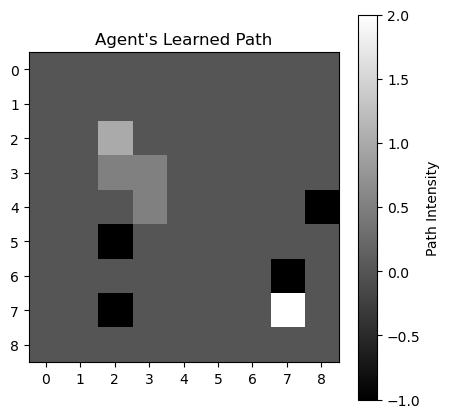

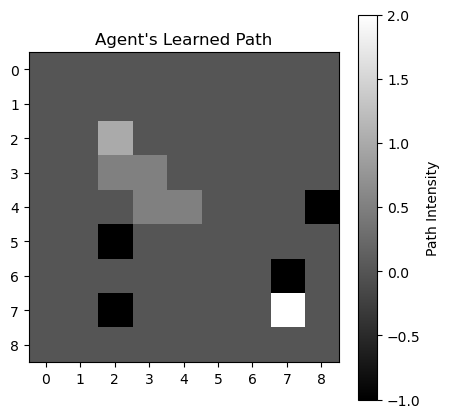

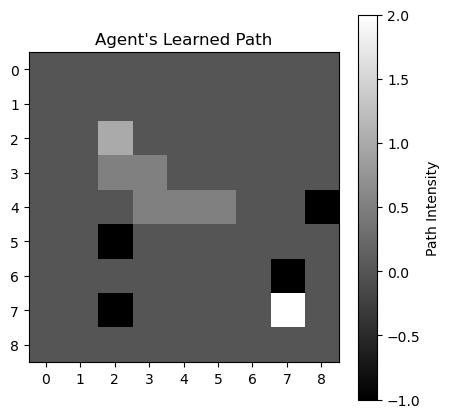

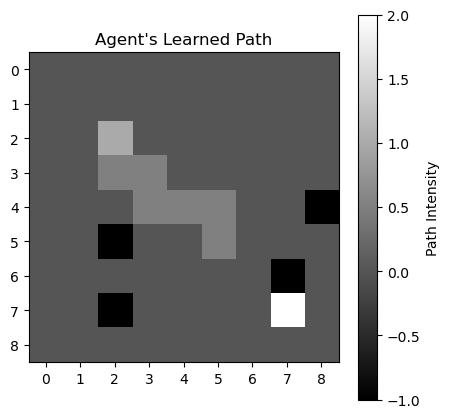

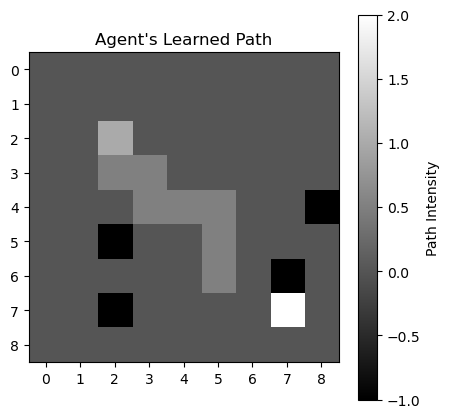

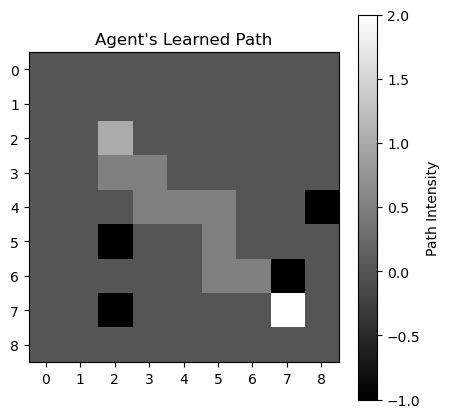

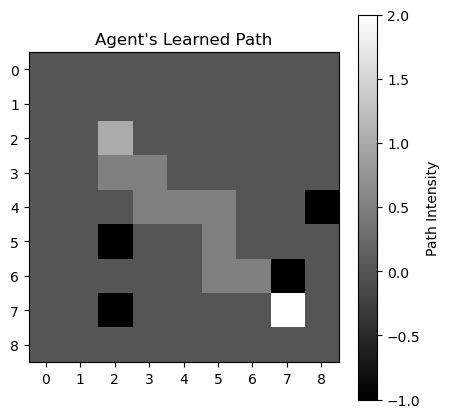

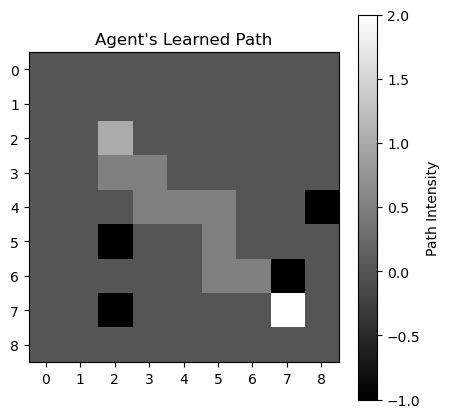

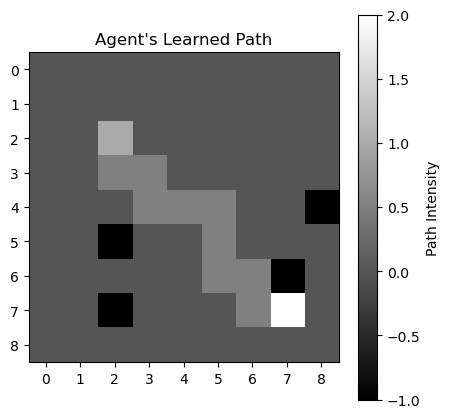

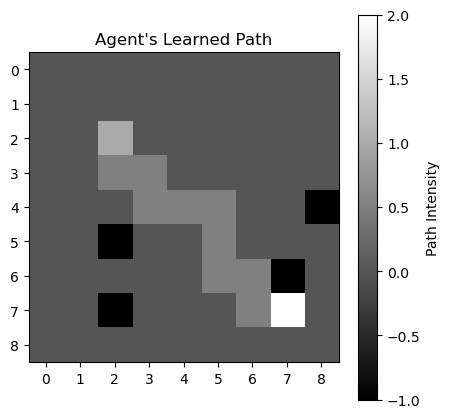

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Function to visualize the agent's path in the maze
def visualize_agent_path(env, agent):
    state = env.reset()
    done = False
    path = [state]  # Store the path taken by the agent

    while not done:
        action = agent.choose_action(state)  # Choose best action based on learned Q-values
        next_state, _, done, _ = env.step(action)
        path.append(next_state)  # Store path
        state = next_state

    # Convert path into a visual grid
    grid_size = env.grid_size
    grid = np.zeros(grid_size)

    # Mark the path
    for step in path:
        grid[step] = 0.5  # Gray for path
        grid[env.start] = 1.0  # Green for start
        grid[env.goal] = 2.0  # Red for goal
        for ob in env.obstacles:
            grid[ob] = -1  # Black for obstacles
    
        # Plot the maze
        plt.figure(figsize=(5, 5))
        plt.imshow(grid, cmap="gray", origin="upper")
        plt.colorbar(label="Path Intensity")
        plt.xticks(range(grid_size[1]))
        plt.yticks(range(grid_size[0]))
        plt.title("Agent's Learned Path")
        plt.show()

# Run the visualization
visualize_agent_path(env, agent)
